In [398]:
import os
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import namedtuple
import heapq
%matplotlib inline
np.random.seed(17)

In [2]:
def diagonal_distance(x1, y1, x2, y2):
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    
    min_d = min(dx, dy)
    max_d = max(dx, dy)
    
    return math.sqrt(2) * min_d + (max_d - min_d)

In [243]:
class Node:
    def __init__(self, x=-1, y=-1, g=math.inf, h=math.inf, f=None, parent=None, last_num=0, lb=-math.inf, ub=math.inf):
        self.x = x
        self.y = y
        self.g = g
        self.lb = lb
        self.ub = ub
        if f is None:
            self.f = self.g + h
        else:
            self.f = f 
        self.parent = parent
        self.last_num = last_num
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __lt__(self, other):
        return self.f < other.f and (self.f == other.f and self.last_num > other.last_num)
    
    def calculate_distance(self, other):
        return math.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)


In [312]:
class Map:
    def __init_(self):
        self.width = 0
        self.height = 0
        self.cells = []
#         self.grid_corners = []
    
    def read_from_string(self, cell_str, width, height):
        self.width = width
        self.height = height
        
        self.cells = [[0 for _ in range(self.width + 1)] for _ in range(self.height + 1)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                        self.cells[i + 1][j] = 1
                        self.cells[i][j + 1] = 1
                        self.cells[i + 1][j + 1] = 1
                    else:
                        continue
                    j += 1
                    
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
            
    def get_cells(self):
        return self.cells
    
    def set_grid_cells(self, width, height, grid_cells):
        self.width = width
        self.height = height
        self.cells = grid_cells
    
        
    def traversable(self, i, j):
        
        if self.cells[i][j] == 1 and self.cells[i + 1][j] == 1 and self.cells[i][j + 1] == 1 and self.cells[i + 1][j + 1] == 1:
            return False
        return True

    
    def in_bounds(self, i, j):
        return (0 <= j < self.width + 1) and (0 <= i < self.height + 1)
    

    def get_neighbors(self, i, j):
        corners = [[-1, 1], [1, 1], [-1, -1], [1, -1]]
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        neighbors = []
        
        for c in corners:
            if self.in_bounds(i + c[0], j + c[1]) and (self.cells[i][j] != 1 or self.cells[i + c[0]][j + c[1]] != 1):
                neighbors.append(Node(i + c[0], j + c[1]))
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and (self.cells[i][j] != 1 or self.cells[i + d[0]][j + d[1]] != 1):
                neighbors.append(Node(i + d[0], j + d[1]))
            else:
                if self.in_bounds(i + d[0], j + d[1]):
                    if d[0] == 1 and j != 0 and i != self.height and j != self.width and (self.traversable(i, j) or self.traversable(i, j - 1)):
                        neighbors.append(Node(i + d[0], j + d[1]))
                    elif d[0] == -1 and i != 0 and j != 0 and j != self.width and (self.traversable(i - 1, j) or self.traversable(i - 1, j - 1)):
                        neighbors.append(Node(i + d[0], j + d[1]))
                    elif d[1] == 1 and i != 0 and i != self.height and (self.traversable(i, j) or self.traversable(i - 1, j)):
                        neighbors.append(Node(i + d[0], j + d[1]))
                    elif d[1] == -1 and i != 0 and i != self.height and j != 0 and (self.traversable(i, j - 1) or self.traversable(i - 1, j - 1)):
                        neighbors.append(Node(i + d[0], j + d[1]))
                    

        return neighbors
    
    def line_of_sight(self, x0, y0, x1, y1):
        dy = y1 - y0
        dx = x1 - x0
        f = 0
        if dy < 0:
            dy = -dy
            sy = -1
        else:
            sy = 1

        if dx < 0:
            dx = -dx
            sx = -1
        else:
            sx = 1

        if dx >= dy:
            while x0 != x1:
                f = f + dy
                if f >= dx:
                    if not self.traversable(x0 + (sx - 1) // 2, y0 + (sy - 1) // 2):
                        return False
                    y0 = y0 + sy
                    f = f - dx
                if f != 0 and not self.traversable(x0 + (sx - 1) // 2, y0 + (sy - 1) // 2):
                    return False
                if dy == 0 and not self.traversable(x0 + (sx - 1) // 2, y0) and not self.traversable(x0 + (sx - 1) // 2, y0 - 1):
                    return False
                x0 = x0 + sx
        else:
            while y0 != y1:
                f = f + dx
                if f >= dy:
                    if not self.traversable(x0 + (sx - 1) // 2, y0 + (sy - 1) // 2):
                        return False
                    x0 = x0 + sx
                    f = f - dy
                if f != 0 and not self.traversable(x0 + (sx - 1) // 2, y0 + (sy - 1) // 2):
                    return False
                if dx == 0 and not self.traversable(x0, y0 + (sy - 1) // 2) and not self.traversable(x0 - 1, y0 + (sy - 1) // 2):
                    return False
                y0 = y0 + sy

        return True

In [99]:
class Open:
    def __init__(self):
        self.elements = []
        self.coords_dict = {}
    
    def __iter__(self):
        return iter(self.coords_dict.values())

    def __len__(self):
        return len(self.coords_dict)

    def is_empty(self):
        if len(self.coords_dict) != 0:
            return False
        return True 

    def get_best_node(self):
        best = heapq.heappop(self.elements)
        coords = (best.x, best.y)
        while self.coords_dict.pop(coords, None) is None:
            best = heapq.heappop(self.elements)
            coords = (best.x, best.y)
        return best
      
    def add_node(self, item : Node):
        coords = (item.x, item.y)
        current_item = self.coords_dict.get(coords)
        if current_item is None or item.g < current_item.g or abs(item.g - current_item.g) < EPS:
            self.coords_dict[coords] = item
            heapq.heappush(self.elements, item)

In [100]:
class Close:
    def __init__(self):
        self.elements = {}

    def __iter__(self):
        return iter(self.elements.values())

    def __len__(self):
        return len(self.elements)

    def add_node(self, item : Node, *args):
        coords = (item.x, item.y)
        self.elements[coords] = item

    def was_expanded(self, item : Node, *args):
        return (item.x, item.y) in self.elements

In [176]:
def calculate_cost(grid_map, s, n):
    
    if s.parent is not None and grid_map.line_of_sight(s.parent.x, s.parent.y, n.x, n.y):
        cost = s.parent.g + s.parent.calculate_distance(n)
        if n.g == math.inf or cost < n.g:
            n.parent = s.parent
            n.g = cost
    else:
        cost = s.g + s.calculate_distance(n)
        if n.g == math.inf or cost < n.g:
            n.parent = s
            n.g = cost

def calculate_cost_astar(grid_map, s, n):
    cost = s.g + s.calculate_distance(n)
    if n.g == math.inf or cost < n.g:
        n.parent = s
        n.g = cost
        

In [177]:
def a_star(grid_map, x_start, y_start, x_goal, y_goal, heuristic_func=diagonal_distance):
    opened = Open()
    closed = Close()
    start_node = Node(x_start, y_start, g=0, h=heuristic_func(x_start, y_start, x_goal, y_goal))
    opened.add_node(start_node)
    last_num = 1
    while not opened.is_empty():
        current_node = opened.get_best_node()
        closed.add_node(current_node)
        if current_node.x == x_goal and current_node.y == y_goal:
            return (True, current_node, closed, opened)
        neighbors = grid_map.get_neighbors(current_node.x, current_node.y)
        for n in neighbors:
            calculate_cost_astar(grid_map, current_node, n)
            n.h = heuristic_func(n.x, n.y, x_goal, y_goal)
            n.f = n.g + n.h
            last_num += 1
            if not closed.was_expanded(n):
                opened.add_node(n)
    return False, None, closed, opened

In [219]:
def post_smooth_path(grid_map, path):
    k = 0
    t_k = path[0]
    new_path = [t_k]
    for i in range(1, len(path) - 1):
        if not grid_map.line_of_sight(t_k.x, t_k.y, path[i].x, path[i].y):
            k = k + 1
            t_k = path[i]
            new_path.append(t_k)
            

    new_path.append(path[len(path) - 1])
    length = 0
    start_point = new_path[0]
    for i in range(1, len(new_path)):
        length += start_point.calculate_distance(new_path[i])
        start_point = new_path[i]
    return (new_path, length)
            

In [102]:
def theta_star(grid_map, x_start, y_start, x_goal, y_goal, heuristic_func=diagonal_distance):
    opened = Open()
    closed = Close()
    start_node = Node(x_start, y_start, g=0, h=heuristic_func(x_start, y_start, x_goal, y_goal))
    opened.add_node(start_node)
    last_num = 1
    while not opened.is_empty():
        current_node = opened.get_best_node()
        closed.add_node(current_node)
        if current_node.x == x_goal and current_node.y == y_goal:
            return (True, current_node, closed, opened)
        neighbors = grid_map.get_neighbors(current_node.x, current_node.y)
        for n in neighbors:
            calculate_cost(grid_map, current_node, n)
            n.h = heuristic_func(n.x, n.y, x_goal, y_goal)
            n.f = n.g + n.h
            last_num += 1
            if not closed.was_expanded(n):
                opened.add_node(n)
    return False, None, closed, opened
    

In [103]:
def make_path(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [165]:
def draw_func(grid_map : Map, start : Node = None, goal : Node = None, path : list = None, nodes_expanded = None, nodes_opened = None):
    hIm = grid_map.height
    wIm = grid_map.width
    current_map = grid_map.get_cells()
    x = []
    y = []
    for i in range(hIm+1):
        for j in range(wIm+1):
            if current_map[i][j] == 1:
                x.append(j)
                y.append(i)
                
    
    xm, ym = np.meshgrid( np.linspace(0, wIm, wIm+1), np.linspace(0, hIm, hIm+1))
    segs1 = np.stack((xm,ym), axis=2)
    segs2 = segs1.transpose(1,0,2)
    plt.gca().add_collection(LineCollection(segs1))
    plt.gca().add_collection(LineCollection(segs2))
    plt.scatter(x, y, c='black')
    if (start is not None) and (grid_map.traversable(start.x, start.y)):
        plt.scatter(start.y, start.x, c='green')
    if (goal is not None) and (grid_map.traversable(goal.x, goal.y)):
        plt.scatter(goal.y, goal.x, c='red')
    if path is not None:
        for n in range(1, len(path)):
            if (path[n] is not None):
                step1 = path[n-1]
                step2 = path[n]
                plt.plot([step1.y, step2.y], [step1.x, step2.x], color='orange')

                    
    plt.show()
    

In [355]:
def simple_test(search_function, astar=False, *args):
    height = 15
    width = 30
    mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(mapstr, width, height )
    start = Node(1, 1)
    goal = Node(13, 28)

    
    try:
        result = search_function(task_map, start.x, start.y, goal.x, goal.y, *args)
        nodes_expanded = result[2]
        nodes_opened = result[3]
        if result[0]:
            path = make_path(result[1])
            if astar:
                path = post_smooth_path(task_map, path[0])
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodes_opened) + len(nodes_expanded)))
            draw_func(task_map, start, goal, path[0], nodes_expanded, nodes_opened)
        else:
            print("Path not found!")
            draw_func(task_map, start, goal, None, nodes_expanded, nodes_opened)
    except Exception as e:
        print("Execution error")
        print(e)
    return path

Path found! Length: 30.85662648942118. Nodes created: 432


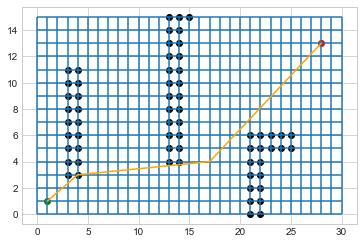

CPU times: user 362 ms, sys: 56.2 ms, total: 418 ms
Wall time: 181 ms


In [356]:
%time path  = simple_test(theta_star)

Path found! Length: 30.270497671438676. Nodes created: 391


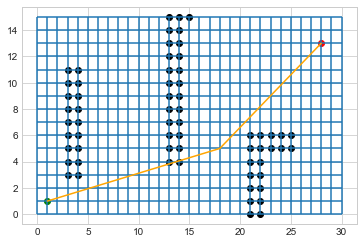

CPU times: user 336 ms, sys: 50.2 ms, total: 387 ms
Wall time: 145 ms


In [357]:
#a_star with post smoothing
%time path  = simple_test(a_star, True)

In [366]:
def ReadTaskFromFile(path):
    tasksFile = open(path)
    count = 0
    height = int(tasksFile.readline())
    width = int(tasksFile.readline())
    cells = [[0 for _ in range(width+1)] for _ in range(height+1)]
    i = 0
    j = 0

    for l in tasksFile:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '#':
                cells[i][j] = 1
                cells[i + 1][j] = 1
                cells[i][j + 1] = 1
                cells[i + 1][j + 1] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    iStart = int(tasksFile.readline())
    jStart = int(tasksFile.readline())
    iGoal = int(tasksFile.readline())
    jGoal = int(tasksFile.readline())
    length = float(tasksFile.readline())
    return (width, height, cells, iStart, jStart, iGoal, jGoal, length)



def MassiveTest(SearchFunction, astar=False, *args):
    stat = dict()
    stat["len"] = []
    taskNum = 2
    taskMap = Map()
    nc = 0
    for taskCount in range(taskNum):
        taskFileName = "Data_simple/" + str(taskCount) + ".map"
        width, height, cells, iStart, jStart, iGoal, jGoal, length = ReadTaskFromFile(taskFileName)
        taskMap.set_grid_cells(width,height,cells)
        try:
            result = SearchFunction(taskMap, iStart, jStart, iGoal, jGoal, *args)
            nodesExpanded = result[2]
            nodesOpened = result[3]
            if result[0]:
                path = make_path(result[1])
                if astar:
                    path = post_smooth_path(taskMap, path[0])
                stat["len"].append(path[1])
                correct = abs(path[1] - length) < EPS
                draw_func(taskMap, Node(iStart, jStart), Node(iGoal, jGoal), path[0], nodesExpanded, nodesOpened)
#                 print("Path found! Length: " + str(path[1]))
                print("Path found! Length: " + str(path[1]))
            else:
                print("Path not found!")
                stat["len"].append(0.0)


        except Exception as e:
            print("Execution error")
            print(e)

    return stat

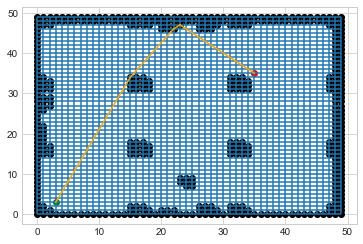

Path found! Length: 65.51876057748936


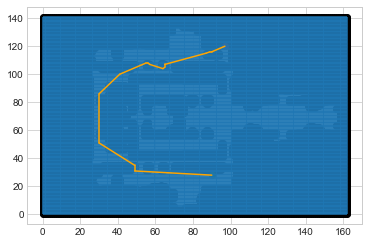

Path found! Length: 187.03002936814704
CPU times: user 1.49 s, sys: 102 ms, total: 1.59 s
Wall time: 883 ms


In [367]:
%time stat = MassiveTest(theta_star)

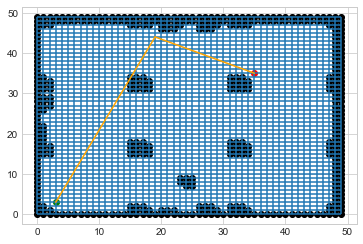

Path found! Length: 62.36892192001659


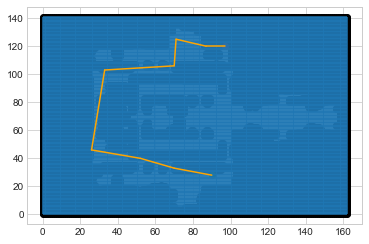

Path found! Length: 206.9510548248357
CPU times: user 1.29 s, sys: 102 ms, total: 1.4 s
Wall time: 682 ms


In [368]:
%time stat = MassiveTest(a_star, True)

In [344]:
def ReadMapFromMovingAIFile(path):
    mapFile = open(path)
    count = 0
    type_m = mapFile.readline()
    height = int(mapFile.readline().split()[1])
    width = int(mapFile.readline().split()[1])
    m = mapFile.readline()
    cells = [[0 for _ in range(width + 1)] for _ in range(height + 1)]
    i = 0
    j = 0 
    
    for l in mapFile:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '@':
                cells[i][j] = 1
                cells[i + 1][j] = 1
                cells[i][j + 1] = 1
                cells[i + 1][j + 1] = 1
            else:
                continue
            j +=1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
        
        i += 1
        if i == height + 1:
            break
        
    return (width, height, cells)

In [345]:
def ReadTasksFromMovingAIFile(path):
    tasks = []
    tasksFile = open(path)
    version = tasksFile.readline()
    i = 0
    for l in tasksFile:
        if i < 900:
            i += 1
            continue
        if i == 1000:
            break
        dt = l.split("\t")
        start_y, start_x = int(dt[4]), int(dt[5])
        goal_y, goal_x = int(dt[6]), int(dt[7])
        length = float(dt[8][:-2])
        tasks.append((start_x, start_y, goal_x, goal_y, length))
        i += 1
    return tasks 

In [397]:
from time import time
def MassiveTestBig(SearchFunction, astar=False, *args):
    allTasksResults = dict()
    allTasksResults["len"] = []
    allTasksResults["nc"] = []
    allTasksResults["time"] = []
    maps_paths = ['./Data/Berlin_0_1024.map', './Data/Boston_2_1024.map', './Data/Milan_2_1024.map']
    taskMap = Map()
    for p in maps_paths:
        width, height, cells = ReadMapFromMovingAIFile(p)
        tasks = ReadTasksFromMovingAIFile(p + '.scen')
        taskMap.set_grid_cells(width,height,cells)
         
        for task in tasks:
            st_time = time()
            iStart, jStart, iGoal, jGoal, length = task

            result = SearchFunction(taskMap, iStart, jStart, iGoal, jGoal, *args)
            nodesExpanded = result[2]
            nodesOpened = result[3]
            if result[0]:
                path = make_path(result[1])
                if astar:
                    path = post_smooth_path(taskMap, path[0])
                allTasksResults["len"].append(path[1])
            else:
                print("Path not found!")
                allTasksResults["len"].append(0.0)
            res_time = time() - st_time
            allTasksResults["nc"].append(len(nodesOpened) + len(nodesExpanded))
            allTasksResults["time"].append(res_time)

    return allTasksResults

In [348]:
theta_stat = MassiveTestBig(theta_star)

In [349]:
a_star_stat = MassiveTestBig(a_star)

In [350]:
a_star_ps_stat = MassiveTestBig(a_star, True)

In [396]:
def plot_statistics(name):
    if name == 'time':
        a = sum(a_sta_stat[name])/len(a_star_stat[name])
        a_ps = sum(a_star_ps_stat[name])/len(a_star_ps_stat[name])
        theta = sum(theta_stat[name])/len(theta_stat[name])
    else:
        a = sum(a_sta_stat[name])/len(a_star_stat[name])
        a_ps = sum(a_star_ps_stat[name])/len(a_star_ps_stat[name])
        theta = sum(theta_stat[name])/len(theta_stat[name])
 

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(name)
    x = ['A*', 'A* PS', 'Theta*']
    y = [a, a_ps, theta]
    ax.bar(x, y)
    plt.show()
    



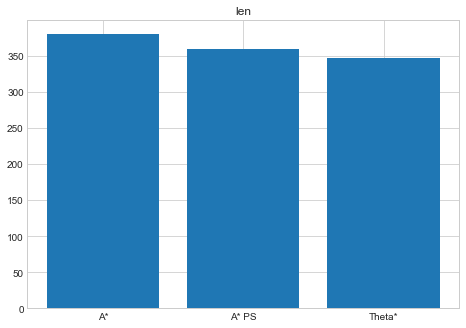

In [372]:
plot_statistics('len')

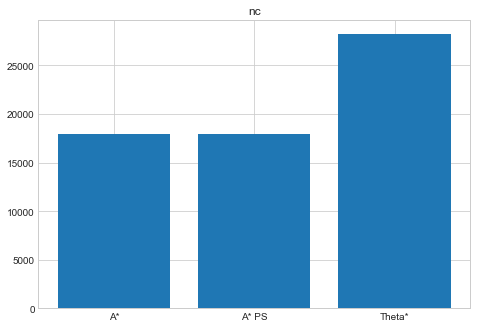

In [388]:
plot_statistics('nc')


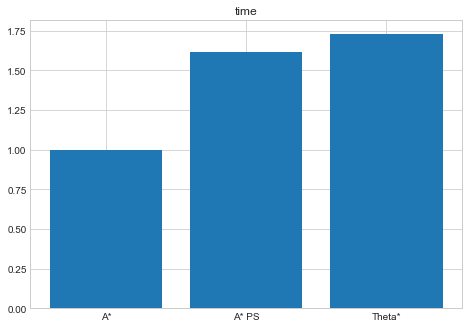

In [395]:
plot_statistics('time')